In [6]:
# Conceptual steps using GTFS Kit
import gtfs_kit as gk
import pandas as pd

# Load the feed
feed = gk.read_feed('GTFS_KRK_A.zip', dist_units='m')

In [7]:
# Check available service dates in the feed
print("Available dates in feed:")
print(feed.get_dates()[:10])  # Show first 10 dates
print(f"\nTotal number of trips: {len(feed.trips)}")
print(f"Total number of stops: {len(feed.stops)}")


Available dates in feed:
['20251004', '20251005', '20251006', '20251007', '20251008', '20251009', '20251010', '20251011', '20251012', '20251013']

Total number of trips: 40200
Total number of stops: 3029


In [8]:
# Filter for the day and time you want to analyze
# Using the first available date from the feed
available_dates = feed.get_dates()
if len(available_dates) > 0:
    selected_date = available_dates[0]
    print(f"Using date: {selected_date}")
    feed = feed.restrict_to_dates([selected_date])
else:
    print("No specific date filter applied - using all trips")

# Extract the stop-to-stop movements (the edges)
stop_df = feed.stop_times.copy()
print(f"Number of stop times: {len(stop_df)}")

stop_df['next_stop_id'] = stop_df.groupby('trip_id')['stop_id'].shift(-1)
stop_df['travel_time'] = stop_df['arrival_time'].apply(lambda x: pd.to_timedelta(x).total_seconds())
stop_df['next_travel_time'] = stop_df.groupby('trip_id')['travel_time'].shift(-1)
# Calculate segment travel time (weight) and clean data
edges_df = stop_df.dropna(subset=['next_stop_id']).copy()
edges_df['weight'] = edges_df['next_travel_time'] - edges_df['travel_time']
print(f"Number of edges created: {len(edges_df)}")

Using date: 20251004
Number of stop times: 125336
Number of edges created: 119523


In [9]:
# Conceptual steps using NetworkX
import networkx as nx

# Create a Directed Graph (since transit is one-way: stop A -> stop B)
G = nx.DiGraph()

# Add edges with attributes (weights)
for index, row in edges_df.iterrows():
    u = row['stop_id']
    v = row['next_stop_id']
    time_weight = row['weight'] # Travel time in seconds

    # Add the edge, using 'weight' for the algorithm
    G.add_edge(u, v, weight=time_weight, route_id=row.get('route_id', 'unknown'))

# Add nodes (stops) with geographical info from feed.stops
for index, stop_row in feed.stops.iterrows():
    G.add_node(stop_row['stop_id'], lat=stop_row['stop_lat'], lon=stop_row['stop_lon'])

print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


Graph created with 2841 nodes and 3485 edges


In [12]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_gtfs_graph(G, title="GTFS Transit Network"):
    """
    Draws the NetworkX graph using geographical coordinates for positioning.
    
    Args:
        G (nx.DiGraph): The graph built from GTFS data.
        title (str): Title for the plot.
    """
    if not G.nodes:
        print("Graph is empty, nothing to draw.")
        return

    # Use the stop's lat/lon data for positioning
    # NetworkX expects a dictionary mapping node IDs to (x, y) coordinates.
    # We use longitude for x and latitude for y.
    pos = {
        node: (data['lon'], data['lat'])
        for node, data in G.nodes(data=True) if 'lon' in data and 'lat' in data
    }
    
    # Ensure there are nodes with positions to draw
    if not pos:
         print("Nodes do not have geographical coordinates (lat/lon) to draw.")
         return

    plt.figure(figsize=(12, 12))
    plt.title(title, fontsize=16)

    # 1. Draw nodes (stops)
    nx.draw_networkx_nodes(
        G, pos,
        node_size=50,
        node_color='skyblue',
        alpha=0.8
    )

    # 2. Draw edges (segments between stops)
    # Using 'zorder' to place edges beneath nodes visually
    nx.draw_networkx_edges(
        G, pos,
        arrowstyle='->',
        arrowsize=10,
        edge_color='gray',
        width=0.5,
        alpha=0.5,
    )
    
    # Optional: Draw specific labels for a few nodes if the graph is small
    # Otherwise, labeling all nodes makes the plot illegible.
    # labels = {node: node for i, node in enumerate(G.nodes()) if i < 5} 
    # nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

    # Set axis limits based on coordinates and show plot
    all_lats = [data['lat'] for data in G.nodes(data=True) if 'lat' in data]
    all_lons = [data['lon'] for data in G.nodes(data=True) if 'lon' in data]
    
    if all_lats and all_lons:
        margin = 0.01 # 1% margin
        plt.xlim(min(all_lons) - margin, max(all_lons) + margin)
        plt.ylim(min(all_lats) - margin, max(all_lats) + margin)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

# Run this function after the graph G is constructed:

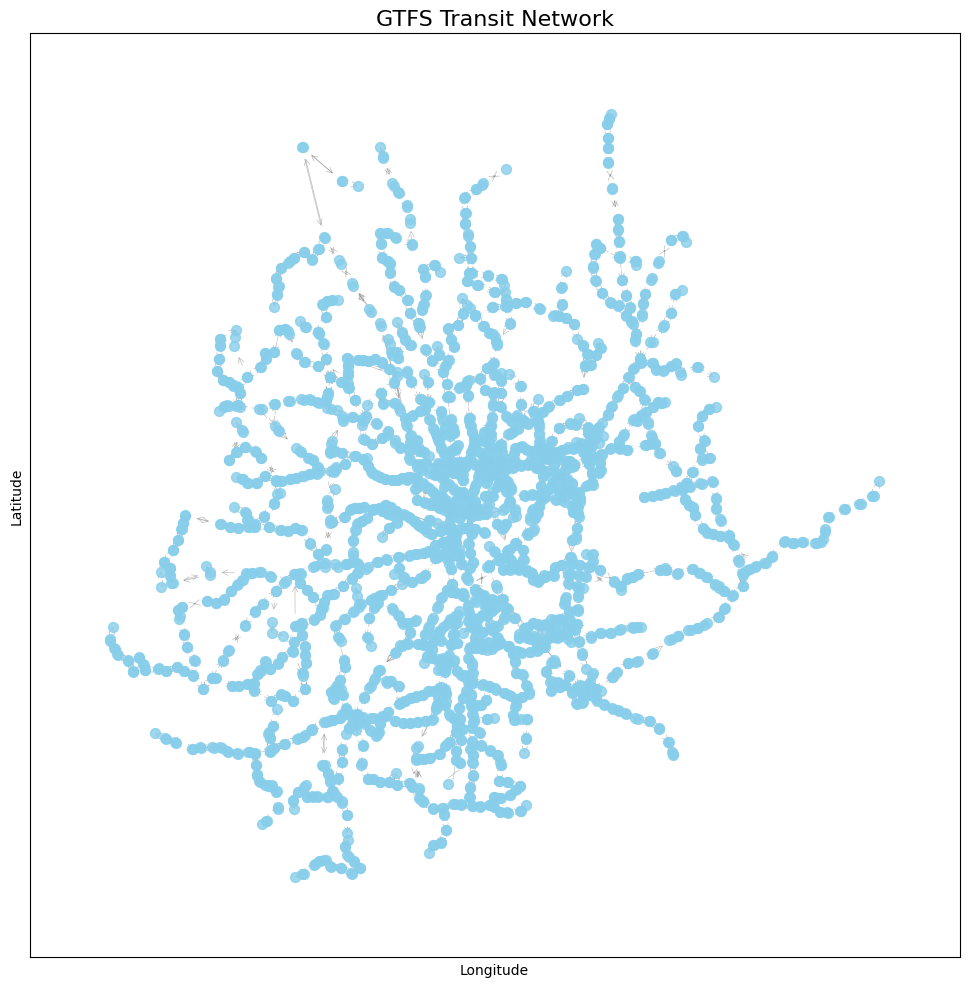

In [13]:
draw_gtfs_graph(G)